# Treinamento de Rede LSTM para classificação

## Libs

In [27]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import kagglehub

import gensim.downloader as gd

import torch
from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tqdm.pandas()

## Funções

In [2]:
def preprocess_text_to_embedding(text: str, embedding_model, max_seq_length: int = 100) -> torch.Tensor:
    # Remove HTML tags and non-alphanumeric characters
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Convert to lowercase and split into words
    text = text.lower()
    words = text.split()
    
    # Truncate to max sequence length
    words = words[:max_seq_length]
    
    # Convert words to embeddings, ignoring words not in the embedding model
    embds = torch.tensor(np.array([embedding_model[w] for w in words if w in embedding_model]))
    
    return embds

In [13]:
def collate_pad(batch):
    xs, ys = zip(*batch)
    
    x_padded = pad_sequence(xs, batch_first=True)
    ys = torch.stack(ys)
    
    return x_padded, ys

## Preparação do Dataset

In [3]:
path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
path = Path(path)

print(f"Diretório principal: {path}")

print("- Arquivos e diretórios filhos:")
for file in path.iterdir():
    print(f"\t{file.name}")

Diretório principal: /home/miguel/.cache/kagglehub/datasets/hgultekin/bbcnewsarchive/versions/1
- Arquivos e diretórios filhos:
	bbc-news-data.csv


In [4]:
data = pd.read_csv(path / 'bbc-news-data.csv', sep='\t')
data.sample(5)

,category,filename,title,content
536,entertainment,027.txt,Lit Idol begins search for author,The second Pop Idol-style search for literary...
1239,politics,344.txt,Will Tory tax cuts lift spirits?,Michael Howard has finally revealed the full ...
1992,tech,169.txt,2D Metal Slug offers retro fun,"Like some drill sergeant from the past, Metal..."
2140,tech,317.txt,Sony PSP console hits US in March,US gamers will be able to buy Sony's PlayStat...
1276,politics,381.txt,Hunt ban support is 'in decline',Support for a ban on hunting has fallen in th...


In [5]:
# APENAS PARA TESTES
data = data.sample(frac=0.1)
data.head(5)

,category,filename,title,content
1346,sport,034.txt,Athens memories soar above lows,"Well, it's goodbye to another Olympic year an..."
695,entertainment,186.txt,Johnny and Denise lose Passport,Johnny Vaughan and Denise Van Outen's Saturda...
1306,politics,411.txt,Howard's unfinished business,"""He's not finished yet,"" whispered the Conser..."
911,politics,016.txt,Crisis 'ahead in social sciences',A national body designed to tackle skills sho...
807,entertainment,298.txt,Spider-Man creator wins profits,Spider-Man creator Stan Lee is to get a multi...


In [6]:
len(data)

222

## Embeddings

In [7]:
gensim_embedding_model = gd.load("glove-twitter-50")

In [8]:
text = data.sample(1)["title"].values[0]

embds = preprocess_text_to_embedding(text=text, embedding_model=gensim_embedding_model)

print(f"Texto: {text}")
print(f"\nEmbeddings shape: {embds.shape}")

Texto: Mobile audio enters new dimension

Embeddings shape: torch.Size([5, 50])


Pré-processando todas as linhas do dataset.

In [9]:
X = [
    preprocess_text_to_embedding(
        text=t,
        embedding_model=gensim_embedding_model
    ) for t in data["content"]
]

print(f"Total de amostras processadas: {len(X)}")

Total de amostras processadas: 222


## Labels

In [10]:
encoder = LabelEncoder()

y = encoder.fit_transform(data["category"])
y = y.astype(np.int64)
y = torch.tensor(y)

y

tensor([3, 1, 2, 2, 1, 4, 3, 1, 1, 1, 3, 4, 3, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 3,
        3, 2, 0, 2, 1, 3, 0, 1, 4, 4, 1, 3, 0, 3, 0, 0, 1, 0, 3, 4, 3, 0, 2, 2,
        2, 4, 4, 0, 1, 3, 1, 3, 0, 0, 1, 4, 4, 2, 2, 4, 2, 2, 3, 0, 4, 2, 1, 0,
        3, 4, 2, 1, 2, 0, 4, 1, 3, 0, 3, 3, 1, 2, 2, 4, 2, 3, 3, 0, 0, 2, 0, 2,
        3, 2, 3, 0, 2, 2, 3, 2, 0, 3, 3, 0, 0, 3, 0, 3, 0, 4, 0, 2, 4, 3, 2, 4,
        4, 2, 2, 0, 2, 1, 2, 4, 2, 1, 2, 4, 0, 1, 3, 4, 4, 3, 3, 0, 2, 3, 3, 3,
        4, 2, 0, 3, 1, 3, 0, 2, 0, 3, 2, 2, 4, 3, 1, 3, 0, 3, 2, 4, 4, 2, 4, 4,
        4, 2, 4, 2, 2, 4, 2, 3, 4, 0, 2, 0, 2, 3, 0, 2, 1, 3, 1, 2, 4, 1, 1, 2,
        1, 3, 1, 3, 0, 3, 3, 0, 3, 1, 2, 4, 2, 3, 0, 3, 3, 2, 0, 4, 1, 0, 3, 2,
        3, 4, 0, 4, 2, 3])

## Dataset e Dataloader

In [14]:
class TextDataset(Dataset):
    def __init__(self, x_list, y_tensor):
        self.x = x_list
        self.y = y_tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

train_ds = TextDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pad)

val_ds = TextDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_pad)

test_ds = TextDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64, collate_fn=collate_pad)

print(f"Total de treino: {len(train_ds)}")
print(f"Total de validação: {len(val_ds)}")
print(f"Total de teste: {len(test_ds)}")

Total de treino: 159
Total de validação: 18
Total de teste: 45


## Model

In [23]:
class Model(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        hidden_size = 32

        self.lstm = nn.LSTM(
            input_size=50,     # embedding size
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        
        dropped = self.dropout(hidden.squeeze(0))
        
        prediction = self.fc(dropped)
        
        return prediction

num_classes = len(encoder.classes_)
net = Model(num_classes=num_classes)

## Treinamento e avaliação

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

history = []
n_epochs = 20

# repete por um número de épocas
for epoch in range(n_epochs):
    running_loss = 0.0

    # epoca de treinamento: itera sobre os batches do conjunto de treino
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_ds)

    # avaliação no conjunto de teste
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_ds)

    history.append([running_loss, val_loss])

    if epoch % max(1, n_epochs // 20)  == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.4f} test loss: {val_loss:.4f}')

print('Finished Training')

[1] loss: 0.0303 test loss: 0.0880
[2] loss: 0.0301 test loss: 0.0877
[3] loss: 0.0300 test loss: 0.0874
[4] loss: 0.0299 test loss: 0.0871
[5] loss: 0.0298 test loss: 0.0868
[6] loss: 0.0294 test loss: 0.0865
[7] loss: 0.0295 test loss: 0.0862
[8] loss: 0.0295 test loss: 0.0858
[9] loss: 0.0294 test loss: 0.0855
[10] loss: 0.0292 test loss: 0.0851
[11] loss: 0.0291 test loss: 0.0848
[12] loss: 0.0291 test loss: 0.0844
[13] loss: 0.0288 test loss: 0.0842
[14] loss: 0.0289 test loss: 0.0839
[15] loss: 0.0283 test loss: 0.0836
[16] loss: 0.0286 test loss: 0.0834
[17] loss: 0.0283 test loss: 0.0831
[18] loss: 0.0281 test loss: 0.0829
[19] loss: 0.0281 test loss: 0.0828
[20] loss: 0.0278 test loss: 0.0825
Finished Training


Evolução da **função de perda** nos conjuntos de treino e validação ao longo do treinamento. 

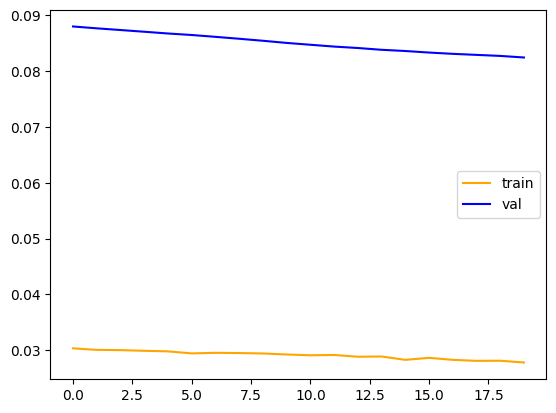

In [25]:
history = np.array(history)

plt.plot(history[:, 0], '-', color='orange', label='train')
plt.plot(history[:, 1], '-', color='blue', label='val')
plt.legend()

## Teste

In [26]:
all_labels = []
preds = []

net.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        
        cls = np.argmax(outputs, axis=-1)
        all_labels += list(labels)
        preds += list(cls)

print(classification_report(all_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         8
           2       0.19      1.00      0.32         6
           3       0.31      0.27      0.29        15
           4       0.00      0.00      0.00         7

    accuracy                           0.22        45
   macro avg       0.10      0.25      0.12        45
weighted avg       0.13      0.22      0.14        45



/home/miguel/Documents/UFES/8_periodo/redes_neurais/T3/lstm-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/miguel/Documents/UFES/8_periodo/redes_neurais/T3/lstm-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/miguel/Documents/UFES/8_periodo/redes_neurais/T3/lstm-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

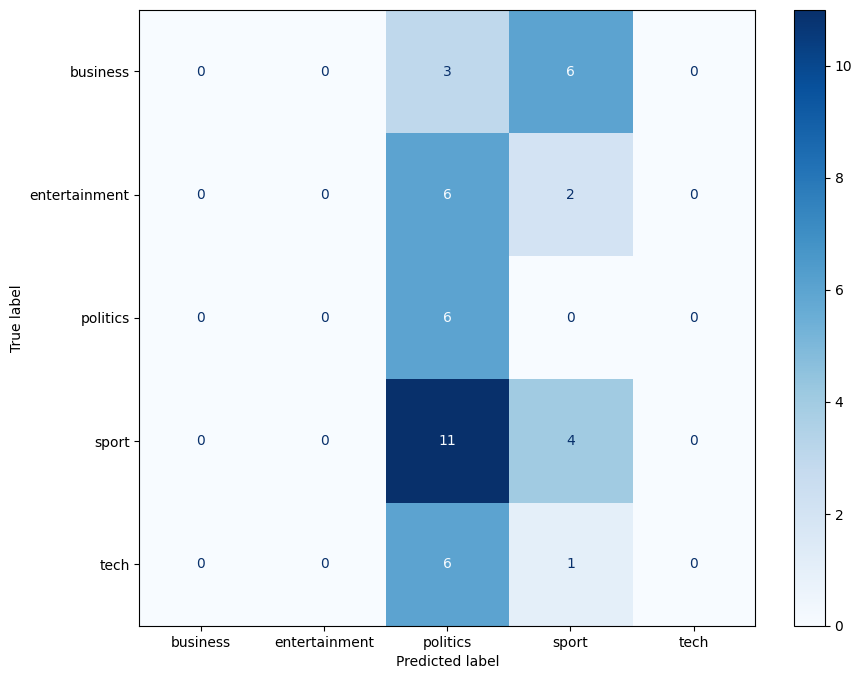

In [30]:
cm = confusion_matrix(all_labels, preds)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()